<div style="border:solid gray 2px; padding: 30px">
    
* Анализ результатов велосипедного заезда групповой гонки с общим стартом на 98км UCI Grand Fondo
* Распределение времени финиширования по группам и возрастным категориям. 

#### **1. Загрузка исходных данных**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_excel(r'datasets\uci_data.xlsx', index_col=0, dtype=({'hour_minute':str}))
df.head(3)

,hour_minute,second,gender,age
1,2.39,53,woman,< 34
2,2.53,36,woman,< 34
3,2.58,19,woman,< 34


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 305 entries, 1 to 305
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   hour_minute  305 non-null    object
 1   second       305 non-null    int64 
 2   gender       305 non-null    object
 3   age          305 non-null    object
dtypes: int64(1), object(3)
memory usage: 11.9+ KB


#### **2. Предобработка**

* замена типа данных секунд и заполнение до двух знаков, для последующего соединения минутами

In [4]:
df['second'] = df['second'].astype(str)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 305 entries, 1 to 305
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   hour_minute  305 non-null    object
 1   second       305 non-null    object
 2   gender       305 non-null    object
 3   age          305 non-null    object
dtypes: object(4)
memory usage: 11.9+ KB


In [5]:
df['second'] = df['second'].str.zfill(2)
df['hour_minute'] = df['hour_minute'].astype(float).map('{:.2f}'.format)
df.head(3)

,hour_minute,second,gender,age
1,2.39,53,woman,< 34
2,2.53,36,woman,< 34
3,2.58,19,woman,< 34


#### **3. Формирование итоговых показателей**

* добавление столбца с временем и замена разделителей для последующего изменения типа данных

In [6]:
df['time'] = df['hour_minute'] + '.' + df['second']
df['time'] = df['time'].str.replace('.', ':')
df.head(3)

,hour_minute,second,gender,age,time
1,2.39,53,woman,< 34,2:39:53
2,2.53,36,woman,< 34,2:53:36
3,2.58,19,woman,< 34,2:58:19


* замена типа данных нового столбца

In [7]:
df['time'] = pd.to_timedelta(df['time'])
df.head(3)

,hour_minute,second,gender,age,time
1,2.39,53,woman,< 34,0 days 02:39:53
2,2.53,36,woman,< 34,0 days 02:53:36
3,2.58,19,woman,< 34,0 days 02:58:19


* добавление нового столбца секунд, для постраения графиков 

In [8]:
df['seconds'] = df['time'].dt.total_seconds().astype(int)
df.head(3)

,hour_minute,second,gender,age,time,seconds
1,2.39,53,woman,< 34,0 days 02:39:53,9593
2,2.53,36,woman,< 34,0 days 02:53:36,10416
3,2.58,19,woman,< 34,0 days 02:58:19,10699


* удаление ненужных столбцов и нулевых дней в записи столбца time

df = df.drop(columns=['hour_minute', 'second'])

In [9]:
df['time'] = df['time'].astype(str).str.split(' ').str[-1]
df.head(3)

,hour_minute,second,gender,age,time,seconds
1,2.39,53,woman,< 34,02:39:53,9593
2,2.53,36,woman,< 34,02:53:36,10416
3,2.58,19,woman,< 34,02:58:19,10699


#### **4. Распределение мест**

* добавление столбца итогового места по времени заезда для общего зачета мужчин и женщин, без разделений на категории по возрасту

In [10]:
df['place'] = df.groupby('gender')['time'].rank(method='first', ascending=True).round()
df.head(3)

,hour_minute,second,gender,age,time,seconds,place
1,2.39,53,woman,< 34,02:39:53,9593,2.0
2,2.53,36,woman,< 34,02:53:36,10416,8.0
3,2.58,19,woman,< 34,02:58:19,10699,10.0


* итоговая таблица итогового места в соревнованиях для женщин

In [11]:
place_w = df.duplicated(subset=['place'], keep='last')
df[place_w].sort_values('place').head(5)

,hour_minute,second,gender,age,time,seconds,place
14,2.37,39,woman,40 - 44,02:37:39,9459,1.0
1,2.39,53,woman,< 34,02:39:53,9593,2.0
9,2.43,01,woman,35 - 39,02:43:01,9781,3.0
10,2.47,11,woman,35 - 39,02:47:11,10031,4.0
23,2.49,01,woman,45 - 49,02:49:01,10141,5.0


#### **5. Гистограмма финиширования по категориям**

* количество участников в каждой группе

In [12]:
df.groupby('age')['age'].count().to_frame()

,age
age,
35 - 39,60
40 - 44,67
45 - 49,50
50 - 54,34
< 34,75
> 55,19


* распределение времени финиширования по возрастным группам

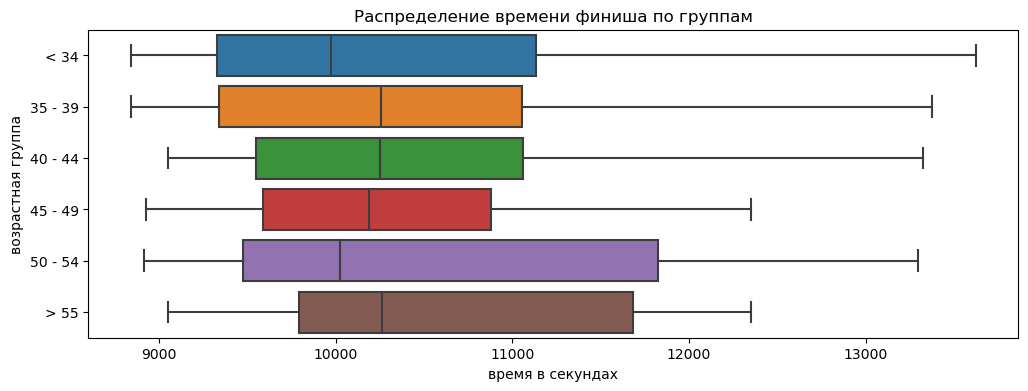

In [13]:
plt.figure(figsize = (12,4))
sns.boxplot(data=df, x="seconds", y="age", showfliers=False)
plt.xlabel('время в секундах')
plt.ylabel('возрастная группа')
plt.title('Распределение времени финиша по группам')
plt.show()

#### **6. Гистограмма финиширования мужчин и женщин**

* гистограмма распределение женщин и мужчин по времени финиширования на соревновании

In [14]:
df_w = df[df['gender']=='woman']
df_m = df[df['gender']=='man']

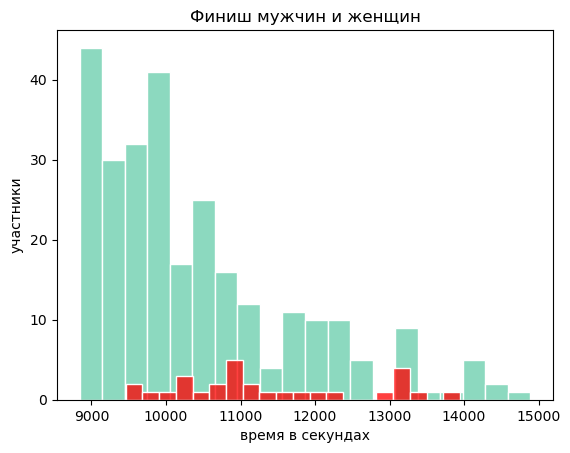

In [15]:
sns.histplot(df_m['seconds'], bins=20, edgecolor='white', color='mediumaquamarine')
sns.histplot(df_w['seconds'], bins=20, edgecolor='white', color='red')
plt.xlabel('время в секундах')
plt.ylabel('участники')
plt.title('Финиш мужчин и женщин')
plt.show()

#### **7. Распределение финишеров по группам**

* распределение финишеров по группам

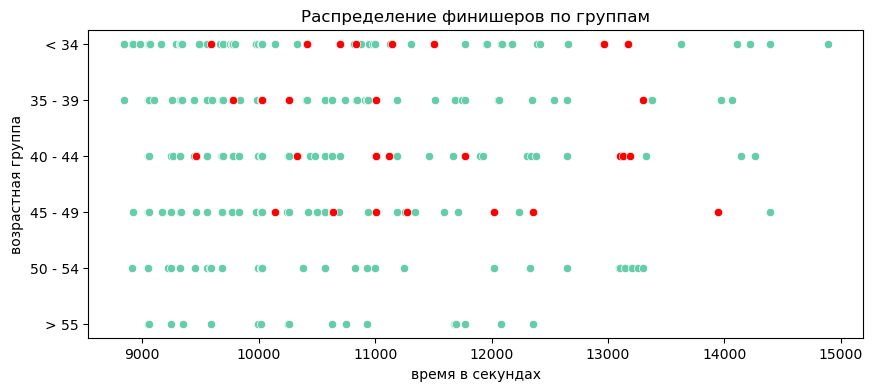

In [16]:
plt.figure(figsize = (10,4))
sns.scatterplot(data=df, x="seconds", y="age", sizes=(20, 250), legend="full", color='mediumaquamarine')
sns.scatterplot(data=df_w, x="seconds", y="age", sizes=(20, 250), legend="full", color='red')

plt.xlabel('время в секундах')  
plt.ylabel('возрастная группа')
plt.title('Распределение финишеров по группам')
plt.show()